# Modeling Section #
## 1. Average Energy prediction

In this section, I'm going to see what pattern appears for average song energy over the years, and predict the scenario for time to come.

In [1]:
# Collecting packages
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, round
import pandas as pd
import numpy as np

In [2]:
# Spark context
sc = SparkContext()

In [3]:
# Spark Session
spark = (
    SparkSession.builder                  
      .appName("music_spark_session")
      .getOrCreate()
)

In [4]:
path_data = "clean_data_music.csv"

schema_music = StructType([
    StructField('Index', IntegerType()),
    StructField('Track_duration', IntegerType()),
    StructField('Popularity', IntegerType()),
    StructField('Danceability', DoubleType()),
    StructField('Energy', DoubleType()),
    StructField('Key', IntegerType()),
    StructField('Loudness', DoubleType()),
    StructField('Acousticness', DoubleType()),
    StructField('Instrumentalness', DoubleType()),
    StructField('Liveness', DoubleType()),
    StructField('Valence', DoubleType()),
    StructField('Tempo', DoubleType()),
    StructField('Year', IntegerType())
])

In [5]:
df = spark.read.csv(
    path_data,
    header=True,
    sep=',',
    schema=schema_music
).drop('index')

In [6]:
df_energy = df.select('Year', 'Energy')\
                 .groupBy('Year').avg('Energy').orderBy('Year')\
                 .withColumnRenamed('avg(Energy)', 'Energy')\
                 .withColumn('Energy', round(col('Energy'), 2))

In [7]:
df_energy = df_energy.toPandas()

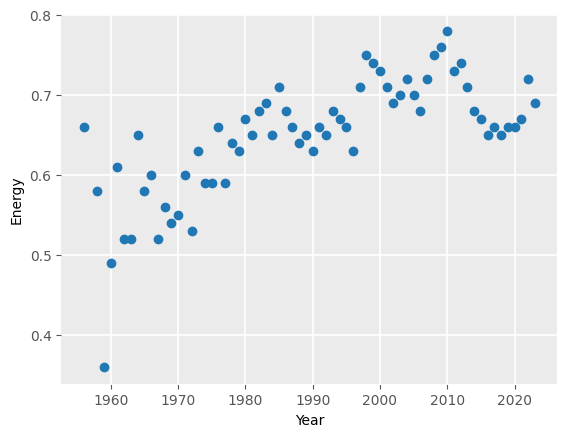

In [8]:
import matplotlib.pyplot as plt

ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.axisbelow':True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': '555555',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': '555555',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}


plt.rcParams.update(ggplot_styles)

plt.scatter(df_energy['Year'], df_energy['Energy'])
plt.xlabel('Year')
plt.ylabel('Energy');

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def fit_model(data, feature: str):
    X = data.drop(feature, axis = 1).copy()
    y = data[feature].copy()
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)
    return X, y, linear_reg

model_1 = fit_model(df_energy, 'Energy')
X = model_1[0]
y = model_1[1]
linear_reg = model_1[2]

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
linear_reg.fit(X_poly, y)
y_fit_poly = linear_reg.predict(X_poly)

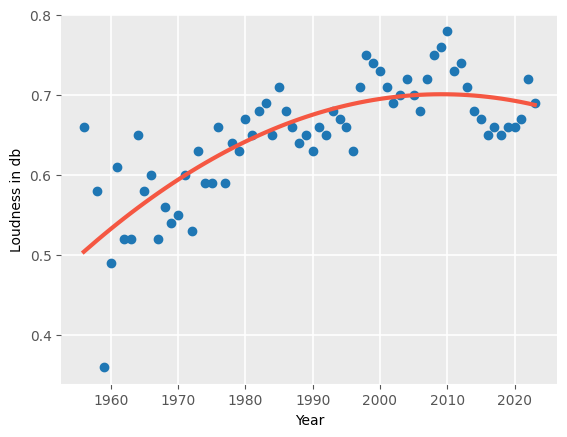

In [10]:
plt.scatter(X, y)
plt.plot(X, y_fit_poly, color = '#f55742', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Loudness in db');

In [11]:
years_list = [i for i in range(2024, 2031)]
df_future = pd.DataFrame(years_list, columns =['Year'])

X_poly = poly_features.fit_transform(df_future)
y_pred_poly = linear_reg.predict(X_poly)

# Simulate points with random
from numpy.random import seed
from numpy.random import randint

seed(7)

y_simulation_points = y_pred_poly + 1/200*randint(0, 10, len(y_pred_poly))

In [12]:
y_pred_points = pd.DataFrame(y_simulation_points)

y_pred_points.rename(columns={0: "Energy_pred"}, inplace= True)
y_pred_points['Year'] = df_future
df_predictions = df_energy.merge(y_pred_points, how = 'outer', on = ['Year'])

C:\Users\Matheus\AppData\Local\Temp\ipykernel_11424\1664175998.py:28: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((historical, prediction),


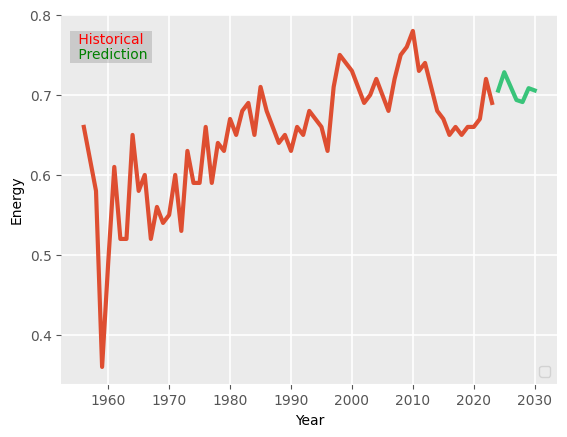

In [17]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1,1)

t1 = axs.text(0.10,0.92, ' Historical ', ha='center', color='red', transform=axs.transAxes)
t2 = axs.text(0.10,0.88, ' Prediction', ha='center', color='green', transform=axs.transAxes)

fig.canvas.draw()

textobjs = [t1,t2]

xmin = min([t.get_window_extent().xmin - 4 for t in textobjs])
xmax = max([t.get_window_extent().xmax + 4 for t in textobjs])
ymin = min([t.get_window_extent().ymin - 2 for t in textobjs])
ymax = max([t.get_window_extent().ymax + 2 for t in textobjs])

xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, facecolor='grey', alpha=0.3, transform=fig.transFigure)

axs.add_patch(rect)

historical = plt.plot(df_predictions['Year'], df_predictions['Energy'], color = '#de4e31', linewidth = 3)
prediction = plt.plot(df_predictions['Year'], df_predictions['Energy_pred'], color = '#39c47a', linewidth = 3)
plt.xlabel('Year')
plt.ylabel('Energy')
plt.legend((historical, prediction),
           ('Historical', 'Prediction'),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=10)
plt.show()

In [16]:
spark.stop()